In [ ]:
import os
import json
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import pandas as pd
import numpy as np
from PIL import Image
import timm
from transformers import GPT2LMHeadModel, GPT2Tokenizer, get_linear_schedule_with_warmup
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f" Using device: {device}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)

🖥️  Using device: cpu


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Define paths
BASE_PATH = '/content/drive/MyDrive/flickr30k_images'
IMAGES_PATH = BASE_PATH
PROCESSED_PATH = os.path.join(BASE_PATH, 'processed')
CHECKPOINT_DIR = os.path.join(PROCESSED_PATH, 'checkpoints')
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# Load dataset statistics
with open(os.path.join(PROCESSED_PATH, 'dataset_stats.json'), 'r') as f:
    dataset_stats = json.load(f)

print(f"\nDataset: {dataset_stats['train_images']:,} train images")
print(f" Checkpoints will be saved to: {CHECKPOINT_DIR}")

Mounted at /content/drive

📊 Dataset: 18,000 train images
📁 Checkpoints will be saved to: /content/drive/MyDrive/flickr30k_images/processed/checkpoints


In [ ]:
class Config:
    # Paths
    base_path = BASE_PATH
    images_path = IMAGES_PATH
    processed_path = PROCESSED_PATH
    checkpoint_dir = CHECKPOINT_DIR

    # Image settings
    img_size = 224

    # Model settings
    swin_model_name = 'swin_tiny_patch4_window7_224'
    swin_embed_dim = 768
    freeze_swin = True
    gpt2_model_name = 'gpt2'
    gpt2_embed_dim = 768
    max_length = 50

    # Training settings
    batch_size = 64  # Adjust based on GPU memory
    num_workers = 2
    num_epochs = 7
    learning_rate = 5e-5
    weight_decay = 0.01
    warmup_steps = 500
    gradient_clip = 1.0

    # Mixed precision training
    use_amp = True  # Automatic Mixed Precision for faster training

    # Checkpointing
    save_every = 1  # Save checkpoint every N epochs

    # Special tokens
    bos_token = '<|startoftext|>'
    eos_token = '<|endoftext|>'
    pad_token = '<|pad|>'

    # Device
    device = device

config = Config()

print(f"\nTraining Configuration:")
print(f"   Epochs: {config.num_epochs}")
print(f"   Batch Size: {config.batch_size}")
print(f"   Learning Rate: {config.learning_rate}")
print(f"   Mixed Precision: {config.use_amp}")
print(f"   Gradient Clipping: {config.gradient_clip}")



⚙️  Training Configuration:
   Epochs: 7
   Batch Size: 64
   Learning Rate: 5e-05
   Mixed Precision: True
   Gradient Clipping: 1.0


In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((config.img_size, config.img_size)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((config.img_size, config.img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

# Initialize tokenizer
tokenizer = GPT2Tokenizer.from_pretrained(config.gpt2_model_name)
special_tokens = {
    'pad_token': config.pad_token,
    'bos_token': config.bos_token,
    'eos_token': config.eos_token
}
tokenizer.add_special_tokens(special_tokens)

print(f"Tokenizer loaded (vocab size: {len(tokenizer):,})")


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

✓ Tokenizer loaded (vocab size: 50,259)


In [ ]:
class FlickrDataset(Dataset):
    def __init__(self, captions_file, images_dir, transform, tokenizer, max_length):
        self.df = pd.read_csv(captions_file)
        self.images_dir = images_dir
        self.transform = transform
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_name = row['image']
        caption = row['caption']

        # Load image
        img_path = os.path.join(self.images_dir, img_name)
        try:
            image = Image.open(img_path).convert('RGB')
            image = self.transform(image)
        except:
            image = torch.zeros(3, 224, 224)

        # Tokenize caption
        caption_text = f"{self.tokenizer.bos_token} {caption} {self.tokenizer.eos_token}"
        encoding = self.tokenizer(
            caption_text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'image': image,
            'caption_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'caption_text': caption
        }


In [ ]:
train_dataset = FlickrDataset(
    os.path.join(config.processed_path, 'train_captions.csv'),
    config.images_path,
    train_transform,
    tokenizer,
    config.max_length
)

val_dataset = FlickrDataset(
    os.path.join(config.processed_path, 'val_captions.csv'),
    config.images_path,
    val_transform,
    tokenizer,
    config.max_length
)

train_loader = DataLoader(train_dataset, batch_size=config.batch_size,
                          shuffle=True, num_workers=config.num_workers,
                          pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=config.batch_size,
                        shuffle=False, num_workers=config.num_workers,
                        pin_memory=True)

print(f"Datasets loaded: {len(train_dataset):,} train, {len(val_dataset):,} val")
print(f"DataLoaders created: {len(train_loader)} train batches, {len(val_loader)} val batches")

✓ Datasets loaded: 90,000 train, 5,000 val
✓ DataLoaders created: 1407 train batches, 79 val batches


In [ ]:
class ImageCaptioningModel(nn.Module):
    def __init__(self, config, tokenizer):
        super(ImageCaptioningModel, self).__init__()
        self.config = config
        self.tokenizer = tokenizer

        # Swin Transformer
        self.swin = timm.create_model(
            config.swin_model_name,
            pretrained=True,
            num_classes=0
        )

        if config.freeze_swin:
            for param in self.swin.parameters():
                param.requires_grad = False

        # Projection
        self.projection = nn.Linear(config.swin_embed_dim, config.gpt2_embed_dim)

        # GPT-2
        self.gpt2 = GPT2LMHeadModel.from_pretrained(config.gpt2_model_name)
        self.gpt2.resize_token_embeddings(len(tokenizer))

        self.image_prefix_length = 1

    def forward(self, images, caption_ids, attention_mask):
        batch_size = images.size(0)

        # Extract image features
        with torch.set_grad_enabled(not self.config.freeze_swin):
            image_features = self.swin(images)

        # Project
        image_embeds = self.projection(image_features).unsqueeze(1)

        # Get caption embeddings
        caption_embeds = self.gpt2.transformer.wte(caption_ids)

        # Concatenate
        input_embeds = torch.cat([image_embeds, caption_embeds], dim=1)

        # Attention mask
        image_attention = torch.ones(batch_size, 1, device=attention_mask.device)
        full_attention_mask = torch.cat([image_attention, attention_mask], dim=1)

        # Forward through GPT-2
        outputs = self.gpt2(
            inputs_embeds=input_embeds,
            attention_mask=full_attention_mask,
            return_dict=True
        )

        # Remove image prefix position
        logits = outputs.logits[:, self.image_prefix_length:, :]

        return logits

    def generate_caption(self, image, max_length=50):
        self.eval()
        with torch.no_grad():
            if image.dim() == 3:
                image = image.unsqueeze(0)
            image = image.to(self.config.device)

            # Extract features
            image_features = self.swin(image)
            image_embeds = self.projection(image_features).unsqueeze(1)

            # Start with BOS
            input_ids = torch.tensor([[self.tokenizer.bos_token_id]], device=self.config.device)

            for _ in range(max_length):
                caption_embeds = self.gpt2.transformer.wte(input_ids)
                input_embeds = torch.cat([image_embeds, caption_embeds], dim=1)
                outputs = self.gpt2(inputs_embeds=input_embeds, return_dict=True)
                next_token_logits = outputs.logits[:, -1, :]
                next_token_id = torch.argmax(next_token_logits, dim=-1, keepdim=True)
                input_ids = torch.cat([input_ids, next_token_id], dim=1)

                if next_token_id.item() == self.tokenizer.eos_token_id:
                    break

            caption = self.tokenizer.decode(input_ids[0], skip_special_tokens=True)

        return caption


In [ ]:
model = ImageCaptioningModel(config, tokenizer)
model = model.to(config.device)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Model initialized")
print(f"   Total parameters: {total_params:,}")
print(f"   Trainable parameters: {trainable_params:,}")


model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


✓ Model initialized
   Total parameters: 152,551,290
   Trainable parameters: 125,031,936


In [ ]:
optimizer = optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)

# Learning rate scheduler with warmup
total_steps = len(train_loader) * config.num_epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=config.warmup_steps,
    num_training_steps=total_steps
)

# Loss function
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)

# Mixed precision scaler
scaler = torch.cuda.amp.GradScaler(enabled=config.use_amp)

In [ ]:
def train_one_epoch(model, train_loader, optimizer, criterion, scheduler, scaler, config, epoch):
    """Train for one epoch"""
    model.train()

    total_loss = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch}/{config.num_epochs} [Train]")

    for batch_idx, batch in enumerate(progress_bar):
        # Move to device
        images = batch['image'].to(config.device)
        caption_ids = batch['caption_ids'].to(config.device)
        attention_mask = batch['attention_mask'].to(config.device)

        # Forward pass with mixed precision
        with torch.cuda.amp.autocast(enabled=config.use_amp):
            logits = model(images, caption_ids, attention_mask)
            shifted_targets = caption_ids[:, 1:].contiguous()  # Remove first token
            logits_for_loss = logits[:, :-1, :].contiguous()  # Remove last prediction

            loss = criterion(
                logits_for_loss.reshape(-1, len(tokenizer)),
                shifted_targets.reshape(-1)
            )

        # Backward pass
        optimizer.zero_grad()
        scaler.scale(loss).backward()

        # Gradient clipping
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), config.gradient_clip)

        # Optimizer step
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        # Update metrics
        total_loss += loss.item()
        avg_loss = total_loss / (batch_idx + 1)

        # Add this right after the forward pass in the train_one_epoch function
# (After: logits = model(images, caption_ids, attention_mask))

        # Update progress bar
        progress_bar.set_postfix({
            'loss': f'{avg_loss:.4f}',
            'lr': f'{scheduler.get_last_lr()[0]:.2e}'
        })

    return total_loss / len(train_loader)

In [ ]:
def validate(model, val_loader, criterion, config):
    """Validate the model"""
    model.eval()

    total_loss = 0
    progress_bar = tqdm(val_loader, desc="Validating")

    with torch.no_grad():
        for batch in progress_bar:
            images = batch['image'].to(config.device)
            caption_ids = batch['caption_ids'].to(config.device)
            attention_mask = batch['attention_mask'].to(config.device)

            # Forward pass
            with torch.cuda.amp.autocast(enabled=config.use_amp):
                logits = model(images, caption_ids, attention_mask)

                shifted_targets = caption_ids[:, 1:].contiguous()
                logits_for_loss = logits[:, :-1, :].contiguous()

                loss = criterion(
                    logits_for_loss.reshape(-1, len(tokenizer)),
                    shifted_targets.reshape(-1)
                )

            total_loss += loss.item()
            progress_bar.set_postfix({'loss': f'{total_loss / (progress_bar.n + 1):.4f}'})

    return total_loss / len(val_loader)

In [ ]:
def generate_sample_captions(model, val_dataset, num_samples=3):
    """Generate sample captions during training"""
    model.eval()

    samples = []
    indices = np.random.choice(len(val_dataset), num_samples, replace=False)

    for idx in indices:
        sample = val_dataset[idx]
        image = sample['image']
        true_caption = sample['caption_text']

        # Generate caption
        generated_caption = model.generate_caption(image, max_length=30)

        samples.append({
            'true': true_caption,
            'generated': generated_caption
        })

    return samples


In [ ]:
def save_checkpoint(model, optimizer, scheduler, epoch, train_loss, val_loss, config, is_best=False):
    """Save model checkpoint"""
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'train_loss': train_loss,
        'val_loss': val_loss,
        'config': config.__dict__
    }

    # Save regular checkpoint
    if epoch % config.save_every == 0:
        path = os.path.join(config.checkpoint_dir, f'checkpoint_epoch_{epoch}.pt')
        torch.save(checkpoint, path)
        print(f" Checkpoint saved: {path}")

    # Save best model
    if is_best:
        path = os.path.join(config.checkpoint_dir, 'best_model.pt')
        torch.save(checkpoint, path)
        print(f" Best model saved: {path}")


In [ ]:

# Training history
history = {
    'train_loss': [],
    'val_loss': [],
    'learning_rate': [],
    'sample_captions': []
}

best_val_loss = float('inf')
start_epoch = 1

# Try to find the most recent checkpoint
checkpoint_files = []
if os.path.exists(config.checkpoint_dir):
    checkpoint_files = [f for f in os.listdir(config.checkpoint_dir)
                       if f.startswith('checkpoint_epoch_') and f.endswith('.pt')]

resume_checkpoint_path = None

if checkpoint_files:
    # Extract epoch numbers and find the latest
    epoch_numbers = []
    for f in checkpoint_files:
        try:
            epoch_num = int(f.replace('checkpoint_epoch_', '').replace('.pt', ''))
            epoch_numbers.append(epoch_num)
        except:
            continue

    if epoch_numbers:
        latest_epoch = max(epoch_numbers)
        resume_checkpoint_path = os.path.join(config.checkpoint_dir, f'checkpoint_epoch_{latest_epoch}.pt')

if resume_checkpoint_path and os.path.exists(resume_checkpoint_path):
    print(f"\nRESUMING FROM CHECKPOINT")
    print(f"   Found checkpoint: {resume_checkpoint_path}")

    try:
        checkpoint = torch.load(resume_checkpoint_path, map_location=config.device)

        # Load model, optimizer, scheduler states
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

        # Set starting epoch (continue from next epoch)
        start_epoch = checkpoint['epoch'] + 1

        # Load complete history if available
        if 'history' in checkpoint:
            history['train_loss'] = checkpoint['history']['train_loss']
            history['val_loss'] = checkpoint['history']['val_loss']
            history['learning_rate'] = checkpoint['history']['learning_rate']
            print(f" Loaded complete training history ({len(history['train_loss'])} epochs)")
        else:
            # Fallback: just use the last checkpoint's metrics
            history['train_loss'] = [checkpoint['train_loss']]
            history['val_loss'] = [checkpoint['val_loss']]
            try:
                prev_lr = checkpoint['scheduler_state_dict']['_last_lr'][0]
            except:
                prev_lr = config.learning_rate
            history['learning_rate'] = [prev_lr]
            print(f"  No history found in checkpoint, starting fresh history")

        # Load best validation loss from best_model.pt if it exists
        best_model_path = os.path.join(config.checkpoint_dir, 'best_model.pt')
        if os.path.exists(best_model_path):
            best_checkpoint = torch.load(best_model_path, map_location='cpu')
            best_val_loss = best_checkpoint['val_loss']
            print(f" Loaded best val loss from best_model.pt: {best_val_loss:.4f}")
        else:
            best_val_loss = checkpoint['val_loss']

        print(f"  Successfully resumed from epoch {checkpoint['epoch']}")
        print(f"  Previous train loss: {checkpoint['train_loss']:.4f}")
        print(f"  Previous val loss: {checkpoint['val_loss']:.4f}")
        print(f"  Best val loss so far: {best_val_loss:.4f}")
        print(f"  Will continue training from epoch {start_epoch}")

    except Exception as e:
        print(f" Error loading checkpoint: {e}")
        print(f" Starting fresh training from epoch 1")
        start_epoch = 1
        best_val_loss = float('inf')
else:
    print(f"\nNo checkpoint found. Starting fresh training from epoch 1")


start_time = time.time()

print(f"\nTraining from epoch {start_epoch} to {config.num_epochs}")
print(f"   Train batches per epoch: {len(train_loader)}")
print(f"   Val batches per epoch: {len(val_loader)}")
print(f"   Estimated time per epoch: ~40-50 minutes")
print("="*70 + "\n")

for epoch in range(start_epoch, config.num_epochs + 1):
    epoch_start = time.time()

    # Train
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion,
                                  scheduler, scaler, config, epoch)

    # Validate
    val_loss = validate(model, val_loader, criterion, config)

    # Generate sample captions
    print("\nSample Captions:")
    samples = generate_sample_captions(model, val_dataset, num_samples=3)
    for i, sample in enumerate(samples, 1):
        print(f"   {i}. True: {sample['true']}")
        print(f"      Gen:  {sample['generated']}\n")

    # Save to history
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['learning_rate'].append(scheduler.get_last_lr()[0])
    history['sample_captions'].append(samples)

    # Check if best model
    is_best = val_loss < best_val_loss
    if is_best:
        best_val_loss = val_loss

    # Save checkpoint
    save_checkpoint(model, optimizer, scheduler, epoch, train_loss, val_loss,
                   config, is_best)

    # Epoch summary
    epoch_time = time.time() - epoch_start
    total_time = time.time() - start_time

    print(f"\n{'='*70}")
    print(f"Epoch {epoch}/{config.num_epochs} Summary:")
    print(f"   Train Loss: {train_loss:.4f}")
    print(f"   Val Loss: {val_loss:.4f} {'(Best!)' if is_best else ''}")
    print(f"   Learning Rate: {scheduler.get_last_lr()[0]:.2e}")
    print(f"   Epoch Time: {epoch_time/60:.1f} minutes")
    print(f"   Total Time: {total_time/60:.1f} minutes")
    print(f"   ETA: {(config.num_epochs - epoch) * epoch_time / 60:.1f} minutes")

    # Clear GPU cache
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

# Save training history
history_path = os.path.join(config.checkpoint_dir, 'training_history.json')
with open(history_path, 'w') as f:
    # Convert to serializable format
    history_save = {
        'train_loss': history['train_loss'],
        'val_loss': history['val_loss'],
        'learning_rate': history['learning_rate']
    }
    json.dump(history_save, f, indent=4)

print(f"\nTraining complete!")
print(f"   Total time: {(time.time() - start_time)/3600:.2f} hours")
print(f"   Best validation loss: {best_val_loss:.4f}")
print(f"   Training history saved: {history_path}")


STARTING TRAINING

🔄 RESUMING FROM CHECKPOINT
   Found checkpoint: /content/drive/MyDrive/flickr30k_images/processed/checkpoints/checkpoint_epoch_3.pt
   ⚠️  No history found in checkpoint, starting fresh history
   ✓ Loaded best val loss from best_model.pt: 2.2924
   ✓ Successfully resumed from epoch 3
   ✓ Previous train loss: 2.2166
   ✓ Previous val loss: 2.2924
   ✓ Best val loss so far: 2.2924
   ✓ Will continue training from epoch 4

🚀 Training from epoch 4 to 7
   Train batches per epoch: 1407
   Val batches per epoch: 79
   Estimated time per epoch: ~40-50 minutes



Epoch 4/7 [Train]:   0%|          | 0/1407 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]


📝 Sample Captions:
   1. True: A football player runs across the field as the referee blows his whistle .
      Gen:   A football player in a blue and white uniform is running with the ball . 

   2. True: Two young blond girls are washing a golden retriever .
      Gen:   A blond woman is sitting on a red convertible . 

   3. True: A corgi is walking down a path in a forest .
      Gen:   Two people are hiking in a forest . 

   💾 Checkpoint saved: /content/drive/MyDrive/flickr30k_images/processed/checkpoints/checkpoint_epoch_4.pt

Epoch 4/7 Summary:
   Train Loss: 2.0937
   Val Loss: 2.3066 
   Learning Rate: 2.26e-05
   Epoch Time: 140.7 minutes
   Total Time: 140.7 minutes
   ETA: 422.0 minutes



Epoch 5/7 [Train]:   0%|          | 0/1407 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]


📝 Sample Captions:
   1. True: This is a you boy with a skateboard
      Gen:   A man in a blue shirt and jeans is hanging from a red and white rope . 

   2. True: A man carves a sculpture with a circular saw .
      Gen:   A man in a yellow shirt and jeans is working on a roof . 

   3. True: A man performs bike tricks by a mural .
      Gen:   A man in a blue shirt is riding a bike on a street . 

   💾 Checkpoint saved: /content/drive/MyDrive/flickr30k_images/processed/checkpoints/checkpoint_epoch_5.pt

Epoch 5/7 Summary:
   Train Loss: 2.0155
   Val Loss: 2.3076 
   Learning Rate: 1.50e-05
   Epoch Time: 20.1 minutes
   Total Time: 160.7 minutes
   ETA: 40.1 minutes



Epoch 6/7 [Train]:   0%|          | 0/1407 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]


📝 Sample Captions:
   1. True: A line of men wearing white in a martial arts class in the middle of delivering a kick .
      Gen:   Two men are practicing karate in a gym . 

   2. True: A girl jumps from an orange raft into a lake .
      Gen:   A girl in a pink bikini jumps into the water . 

   3. True: A band on stage signing to a group of fans .
      Gen:   A group of people are standing around a man in a black shirt . 

   💾 Checkpoint saved: /content/drive/MyDrive/flickr30k_images/processed/checkpoints/checkpoint_epoch_6.pt

Epoch 6/7 Summary:
   Train Loss: 1.9846
   Val Loss: 2.3064 
   Learning Rate: 7.52e-06
   Epoch Time: 19.4 minutes
   Total Time: 180.1 minutes
   ETA: 19.4 minutes



Epoch 7/7 [Train]:   0%|          | 0/1407 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]


📝 Sample Captions:
   1. True: Two asian men walking down the street holding red bags .
      Gen:   A man in a red shirt is walking down the street with a red bag . 

   2. True: A young girl plays the flute as she looks down at a book while reading the notes .
      Gen:   A man in a black shirt is playing a violin . 

   3. True: People standing around in a library .
      Gen:   A woman in a blue shirt is teaching a class . 

   💾 Checkpoint saved: /content/drive/MyDrive/flickr30k_images/processed/checkpoints/checkpoint_epoch_7.pt

Epoch 7/7 Summary:
   Train Loss: 2.0376
   Val Loss: 2.2930 
   Learning Rate: 0.00e+00
   Epoch Time: 18.3 minutes
   Total Time: 198.3 minutes
   ETA: 0.0 minutes


✅ Training complete!
   Total time: 3.31 hours
   Best validation loss: 2.2924
   Training history saved: /content/drive/MyDrive/flickr30k_images/processed/checkpoints/training_history.json


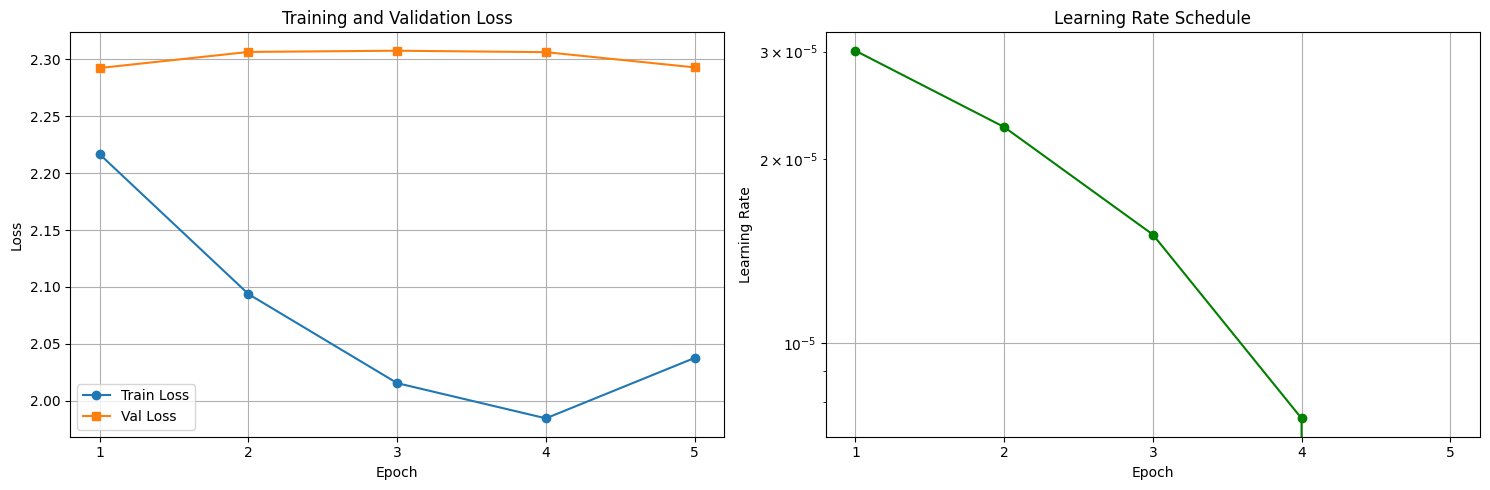

In [ ]:

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Create epoch numbers (1, 2, 3, ...)
epochs = range(1, len(history['train_loss']) + 1)

# Loss curves
axes[0].plot(epochs, history['train_loss'], label='Train Loss', marker='o')
axes[0].plot(epochs, history['val_loss'], label='Val Loss', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].set_xticks(epochs)  # Set integer ticks
axes[0].legend()
axes[0].grid(True)

axes[1].plot(epochs, history['learning_rate'], marker='o', color='green')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Learning Rate')
axes[1].set_title('Learning Rate Schedule')
axes[1].set_xticks(epochs)  # Set integer ticks
axes[1].set_yscale('log')
axes[1].grid(True)

plt.tight_layout()
plt.savefig(os.path.join(config.checkpoint_dir, 'training_curves.png'), dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
print(f"\nFinal Results:")
print(f"   Best Val Loss: {best_val_loss:.4f}")
print(f"   Final Train Loss: {history['train_loss'][-1]:.4f}")
print(f"   Final Val Loss: {history['val_loss'][-1]:.4f}")



📊 Final Results:
   Best Val Loss: 2.2924
   Final Train Loss: 2.0376
   Final Val Loss: 2.2930


In [ ]:
batch = next(iter(train_loader))

print("Batch shapes:")
print(f"  Images: {batch['image'].shape}")
print(f"  Caption IDs: {batch['caption_ids'].shape}")
print(f"  Attention mask: {batch['attention_mask'].shape}")

print("\nFirst 3 captions:")
for i in range(3):
    print(f"\n{i+1}. Text: {batch['caption_text'][i]}")
    print(f"   Token IDs: {batch['caption_ids'][i][:20].tolist()}")
    print(f"   Decoded: {tokenizer.decode(batch['caption_ids'][i][:20])}")
    print(f"   Pad token ID: {tokenizer.pad_token_id}")
    print(f"   Number of non-pad tokens: {(batch['caption_ids'][i] != tokenizer.pad_token_id).sum().item()}")

Batch shapes:
  Images: torch.Size([64, 3, 224, 224])
  Caption IDs: torch.Size([64, 50])
  Attention mask: torch.Size([64, 50])

First 3 captions:

1. Text: A woman walks toward the top of an escalator , with a castle in the background outside the windows .
   Token IDs: [50258, 317, 2415, 11114, 3812, 262, 1353, 286, 281, 12221, 1352, 837, 351, 257, 16669, 287, 262, 4469, 2354, 262]
   Decoded: <|startoftext|> A woman walks toward the top of an escalator , with a castle in the background outside the
   Pad token ID: 50257
   Number of non-pad tokens: 24

2. Text: A group of people pull a jeep stuck on a rock .
   Token IDs: [50258, 317, 1448, 286, 661, 2834, 257, 11223, 538, 7819, 319, 257, 3881, 764, 220, 50256, 50257, 50257, 50257, 50257]
   Decoded: <|startoftext|> A group of people pull a jeep stuck on a rock . <|endoftext|><|pad|><|pad|><|pad|><|pad|>
   Pad token ID: 50257
   Number of non-pad tokens: 16

3. Text: Several woman talking around a table , a woman with blond-hair s

In [ ]:
checkpoint_path = '/content/drive/MyDrive/flickr30k_images/processed/checkpoints/checkpoint_epoch_3.pt'
checkpoint = torch.load(checkpoint_path, map_location='cpu')

print("Checkpoint info:")
print(f"  Epoch: {checkpoint['epoch']}")
print(f"  Train loss: {checkpoint['train_loss']}")
print(f"  Val loss: {checkpoint['val_loss']}")

if 'history' in checkpoint:
    print(f"\n Has history: {len(checkpoint['history']['train_loss'])} epochs")
    print(f"  Train: {checkpoint['history']['train_loss']}")
    print(f"  Val: {checkpoint['history']['val_loss']}")
else:
    print("\n No history in checkpoint")

Checkpoint info:
  Epoch: 3
  Train loss: 2.2165585834249675
  Val loss: 2.292433468601372

❌ No history in checkpoint


NameError: name 'history' is not defined

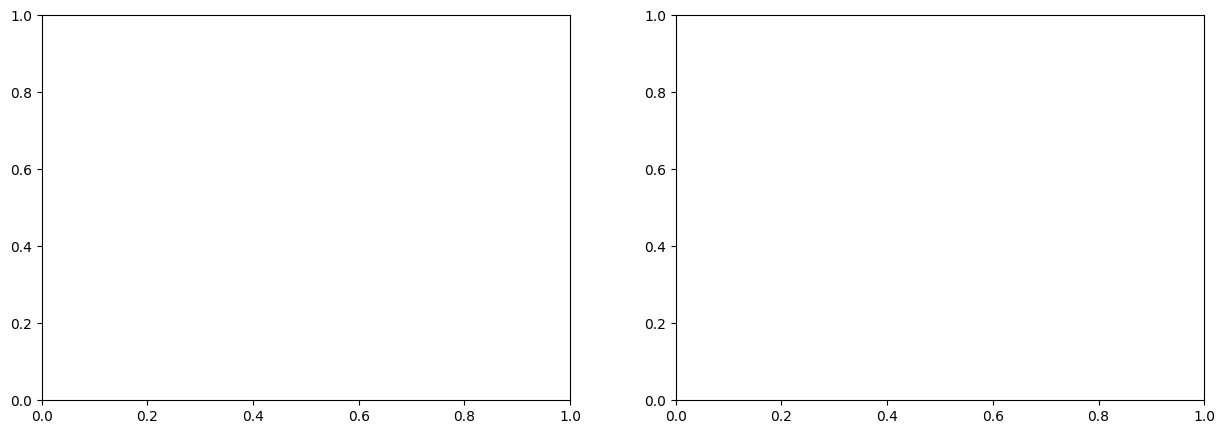

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Create epoch numbers (1, 2, 3, ...)
epochs = range(1, len(history['train_loss']) + 1)

# Loss curves
axes[0].plot(epochs, history['train_loss'], label='Train Loss', marker='o')
axes[0].plot(epochs, history['val_loss'], label='Val Loss', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].set_xticks(epochs)  # Set integer ticks
axes[0].legend()
axes[0].grid(True)

# Learning rate
axes[1].plot(epochs, history['learning_rate'], marker='o', color='green')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Learning Rate')
axes[1].set_title('Learning Rate Schedule')
axes[1].set_xticks(epochs)  # Set integer ticks
axes[1].set_yscale('log')
axes[1].grid(True)

plt.tight_layout()
plt.savefig(os.path.join(config.checkpoint_dir, 'training_curves.png'), dpi=300, bbox_inches='tight')
plt.show()

print(" Training curves saved!")

Epochs: [1, 2, 3, 4, 5, 6, 7]
Number of train loss values: 7
Number of val loss values: 7
Number of LR values: 7

✓ Saved to: /content/drive/MyDrive/flickr30k_images/processed/checkpoints/training_curves_complete_7epochs.png


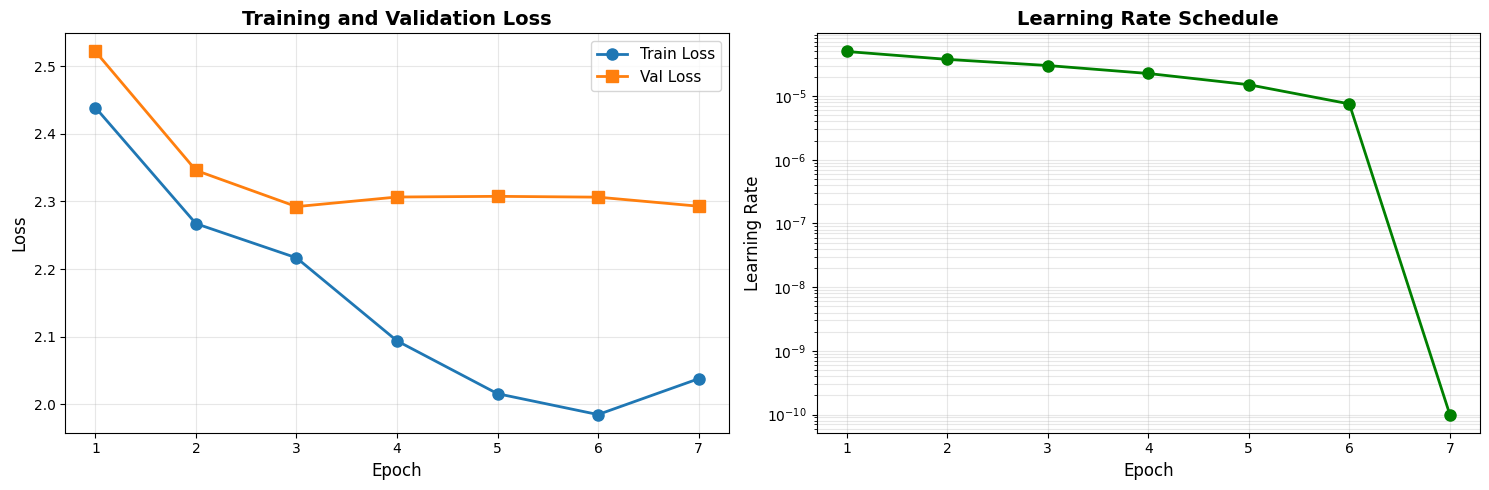


TRAINING SUMMARY (7 EPOCHS)

Train Loss:
  Epoch 1: 2.4390
  Epoch 2: 2.2672
  Epoch 3: 2.2166
  Epoch 4: 2.0937
  Epoch 5: 2.0155
  Epoch 6: 1.9846
  Epoch 7: 2.0376

Validation Loss:
  Epoch 1: 2.5220
  Epoch 2: 2.3460
  Epoch 3: 2.2924
  Epoch 4: 2.3066
  Epoch 5: 2.3076
  Epoch 6: 2.3064
  Epoch 7: 2.2930

Best Val Loss: 2.2924 (Epoch 3)
Final Train Loss: 2.0376
Final Val Loss: 2.2930


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Complete 7-epoch history (manually entered)
train_loss = [2.439, 2.2672, 2.2166, 2.0937, 2.0155, 1.9846, 2.0376]
val_loss = [2.522, 2.3460, 2.2924, 2.3066, 2.3076, 2.3064, 2.2930]
learning_rate = [5e-5, 3.76e-05, 3.0099e-05, 2.2575e-05, 1.5050e-05, 7.5249e-06, 1e-10]  # Changed last from 0 to 1e-10 for log scale

epochs = list(range(1, 8))  # [1, 2, 3, 4, 5, 6, 7]

print(f"Epochs: {epochs}")
print(f"Number of train loss values: {len(train_loss)}")
print(f"Number of val loss values: {len(val_loss)}")
print(f"Number of LR values: {len(learning_rate)}")

# Create figure
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Loss curves
axes[0].plot(epochs, train_loss, label='Train Loss', marker='o', linewidth=2, markersize=8, color='#1f77b4')
axes[0].plot(epochs, val_loss, label='Val Loss', marker='s', linewidth=2, markersize=8, color='#ff7f0e')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0].set_xticks(epochs)
axes[0].set_xticklabels(epochs)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Plot 2: Learning rate
axes[1].plot(epochs, learning_rate, marker='o', linewidth=2, markersize=8, color='green')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Learning Rate', fontsize=12)
axes[1].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
axes[1].set_xticks(epochs)
axes[1].set_xticklabels(epochs)
axes[1].set_yscale('log')
axes[1].grid(True, alpha=0.3, which='both')

plt.tight_layout()

# Save
save_path = '/content/drive/MyDrive/flickr30k_images/processed/checkpoints/training_curves_complete_7epochs.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"\n✓ Saved to: {save_path}")

plt.show()

# Print summary
print("\n" + "="*70)
print("TRAINING SUMMARY (7 EPOCHS)")
print("="*70)
print("\nTrain Loss:")
for i, loss in enumerate(train_loss, 1):
    print(f"  Epoch {i}: {loss:.4f}")

print("\nValidation Loss:")
for i, loss in enumerate(val_loss, 1):
    print(f"  Epoch {i}: {loss:.4f}")

print(f"\nBest Val Loss: {min(val_loss):.4f} (Epoch {val_loss.index(min(val_loss)) + 1})")
print(f"Final Train Loss: {train_loss[-1]:.4f}")
print(f"Final Val Loss: {val_loss[-1]:.4f}")